(assignment_2)=
# Assignment 2: Wind-driven channel flow and basin-scale flow

For this assignment you will do quantiative analysis of the channel flow (see {ref}`assignment_1`), and a qualitative analysis of flow in a basin under wind stress curl.  

## Q1.1  Stress with no rotation

For the simulation with no rotation (`channelnof`), plot a profile of the x-momentum stress that is transmitted in the vertical direction at a point in the middle of the channel.  Do this at something like 12 h into the simulation.  

What is the net acceleration of the water parcel due to this stress profile?  

Recall that the surface stress is equal to $\tau_w = 0.2 \ \mathrm{N\,m^{-2}}$, and the vertical viscosity is $\kappa = 3\times10^{-3}\ \mathrm{m^2\,s^{-1}}$.  What will the velocity and stress profile look like at steady state (flow no longer accelerating), or is there a steady state? 




In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# use the matplotlib widget
%matplotlib widget

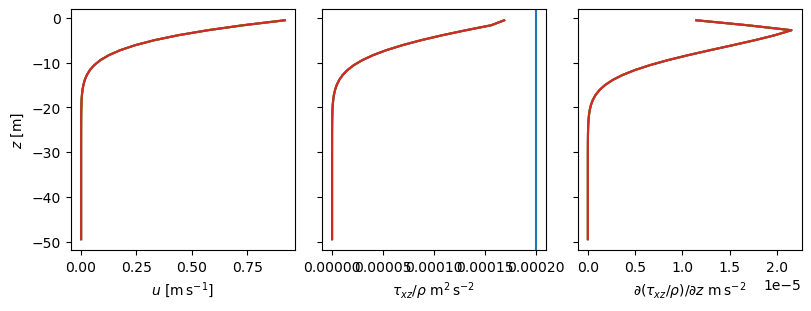

In [2]:
with xr.open_dataset('channelnof.snapshot.nc') as ds:
    ds = ds.isel(Time=5).sel(yt=10, yu=10, method='nearest')
    fig, axs = plt.subplots(1, 3, layout='constrained', sharey=True, figsize=(8, 3))
    ax = axs[0]
    ax.plot(ds.u, ds.zt)
    ax.set_xlabel('$u \ \mathrm{[m\,s^{-1}]}$')
    ax.set_ylabel('$z \ \mathrm{[m]}$')
    ax = axs[1]
    ax.plot(ds.u.differentiate(coord='zt')*1e-3, ds.zt)
    ax.axvline(0.2/1000)
    ax.set_xlabel(r'$\tau_{xz}/\rho \ \mathrm{m^2\,s^{-2}}$')
    ax = axs[2]
    ax.plot(ds.u.differentiate(coord='zt').differentiate(coord='zt')*1e-3, ds.zt)
    ax.set_xlabel(r'$\partial (\tau_{xz}/\rho) / \partial z \ \mathrm{m\,s^{-2}}$')
    

This flow is not in steady state yet.  Steady state would be a linear profile of velocity with $\nu \partial u / \partial z = \tau_w / \rho$ so $u(z=0) = 10 \ \mathrm{m\,s^{-1}}$.  This would lead to a constant stress through the water column As it is, the flow is faster above than below, and the stress is higher with increasing z, so momentum is converging with depth and $\partial u / \partial t>0$.   

Note that the time scale for this to be in steady state is $T\approx H^2 / \kappa \approx 28$ days, so we would have to run the simulation for considerably longer to see the steady state behaviour.

## Q1.2 Geostrophic balance (interior)

For the f-plane simulation (`channelfplane`) show that the interior of the flow (away from the Ekman layers) is approximately in geostrophic balance with the surface flow.  Note that $f=10^{-4}\ \mathrm{rad\,s^{-1}}$.  I did this by comparing the size of $u$ with the size of $(g/f) \partial  \eta / \partial y$ across the whol y-z cross-section.  

```{hint}
Remember that the surface pressure, $g\eta$, is given by `psi` in veros.
```

Describe where in the water column the geostrophic balance is poor.   

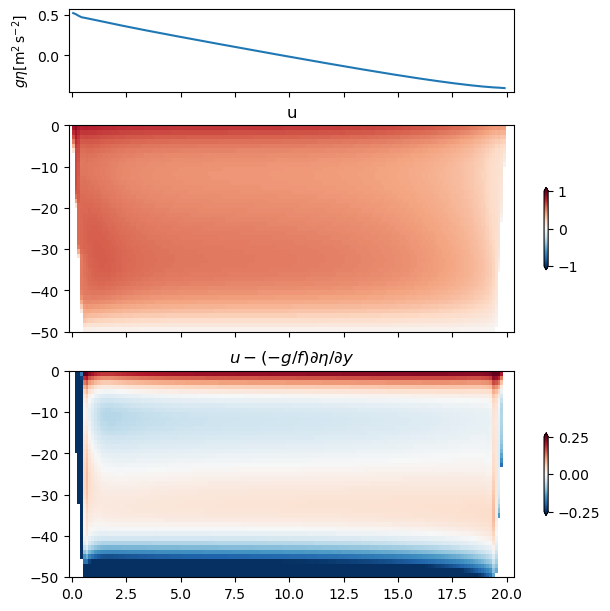

In [3]:
# fu = - g d eta/dx
f = 1e-4
with xr.open_dataset('channelfplane.snapshot.nc') as ds:
    ds = ds.isel(Time=-1, xt=1, xu=1)
    fig, axs = plt.subplots(3, 1, figsize=(6, 6), height_ratios=[0.4, 1, 1], sharex=True, layout='constrained')
    ax = axs[0]
    ax.plot(ds.yt, ds.psi)
    ax.set_ylabel('$g \eta \mathrm{[m^2\,s^{-2}]}$')
    ax = axs[1]
    pc = ax.pcolormesh(ds.yt, ds.zt, ds.u, vmin=-1, vmax=1, cmap='RdBu_r')
    fig.colorbar(pc, ax=ax, shrink=0.4, extend='both')
    ax.set_title('u')
    ax = axs[2]
    pc = ax.pcolormesh(ds.yt, ds.zt, ds.u + ds.psi.differentiate(coord='yt') / f / 1000 , vmin=-0.25, vmax=0.25, cmap='RdBu_r')
    ax.set_title('$u - (-g/f) \partial \eta / \partial y$')
    fig.colorbar(pc, ax=ax, shrink=0.4, extend='both')    

The flow is close to being in Geostrophic balance, with a small interior flow that is not quite in balance.

## Q1.3 Ekman balance

Plot as a time-series and demonstrate that the Ekman Transport reaches the expected value in the upper part of the water column and that there is an equal and opposite Ekman transport in the bottom boundary layer.  You can do this with y at the center of the channel.  

```{hint}
The tendency would be to use `integrate` to do the integral.  However a lot of the Ekman transport is in the first grid cell, and the trapezoid rule does a poor job at the boundary.  Suggest you use `sum` instead (and multiply by the correct dz for each cell).

```


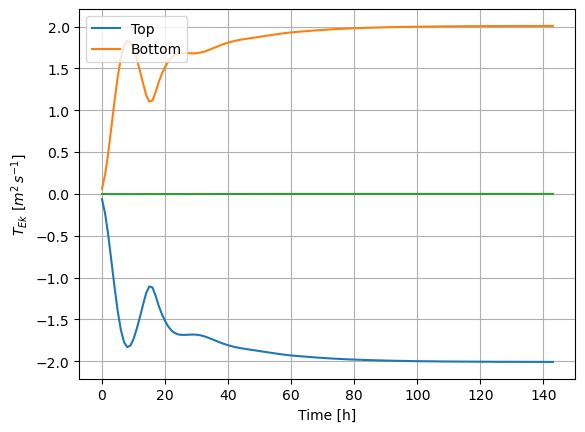

In [4]:
dz = 50/45
with xr.open_dataset('../Assign1/channelfplane.snapshot.nc') as ds:
    ds = ds.isel(xt=0, xu=0).sel(yt=10, yu=10, method='nearest')
    vEkSurf = ds.v.sel(zt=slice(-25, 1)).sum(dim='zt') * dz
    fig, ax = plt.subplots()
    ax.plot(vEkSurf, label='Top')
    vEkBott = ds.v.sel(zt=slice(-70, -25)).sum(dim='zt') * dz
    ax.plot(vEkBott, label='Bottom')
    ax.grid('on')
    ax.legend()
    ax.plot(ds.v.sum(dim='zt') * 50 /45)
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('$T_{Ek}\ [m^2\,s^{-1}]$')

## Q1.4 Ekman spiral

Show that the velocity in the upper and lower Ekman layers follow the Ekman spiral solution in the upper ocean and near the sea floor.  Also add the two Ekman layer solutions together and compare to the observed profile.


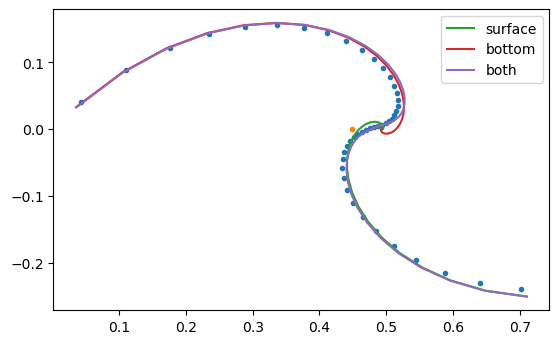

In [5]:

with xr.open_dataset('../Assign1/channelfplane.snapshot.nc') as ds:
    ds = ds.isel(xt=0, xu=0, Time=-1).sel(yt=10, yu=10, method='nearest')
    fig, ax = plt.subplots()
    
    ax.plot(ds.u, ds.v, '.')
    ax.plot(ds.u.mean(), ds.v.mean(), '.')
    d = np.sqrt(2*3e-3 / 1e-4)
    z = ds.zt
    taux=0.2
    u0 = ds.u.isel(zt=22) #, method='nearest')
    
    uEk = np.sqrt(2)/1024/1e-4/d * np.exp(z/d) * (taux *np.cos(z/d - np.pi / 4))
    vEk = np.sqrt(2)/1024/1e-4/d * np.exp(z/d) * (taux *np.sin(z/d - np.pi / 4))
    ax.plot(uEk+u0, vEk, label='surface')

    uEkB = u0 * (1 - np.exp(-(50+z)/d) * np.cos((50+z)/d))
    vEkB = u0 * np.exp(-(50+z)/d) * np.sin((50+z)/d)
    ax.plot(uEkB, vEkB, label='bottom')
    
    ax.plot(uEkB+uEk, vEkB+vEk, label='both')
    ax.legend()
    ax.set_aspect(1)
    
    

## Q2: Wind-driven basin: Qualitative

In this simulation an 80x80km 200-m deep basin is used.  Wind is blown on it so that it blows strongest to the west at the south side of the box, and strongest to the east atthe top of the box, so $\tau_x^w = -0.1 \cos\left(\pi \frac{y}{y_{max}}\right)$.  There are two runs, where $f=f_0 = 10^{-4}\ \mathrm{rad \, s^{-1}}$, and a second where f increases towards the north: $f = f_0 + \left( 10^{-9} \left( ms \right)^{-1} \right) y$

To make the simulation output, please run `basinfplane.py` and `basinbetaplane.py`.

### Q2.1: plot the wind stress as a function of y 

Note that this is stored in `ds.surface_taux` (and `ds.surface_tauy`).  Describe a) what direction youd expect the Ekman transport to be at $y=40\ \mathrm{km}$ and at $y=130\ \mathrm{km}$ b) describe what must happen between these two "latitudes" given these Ekman transports.  c) What direction is the water being "torqued" (twisted)?  d) hwo do you think the water will move in this flow given that it will be close to geostrophic balance.



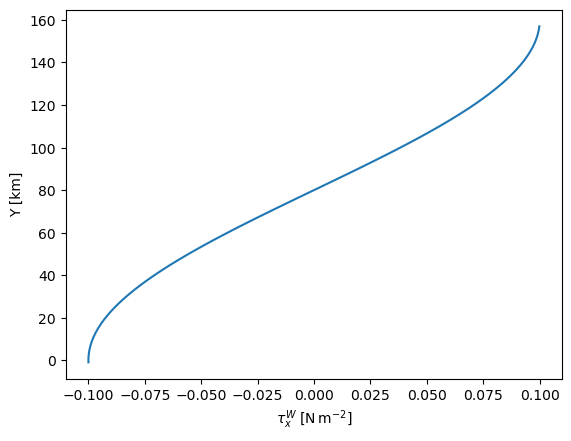

In [6]:
with xr.open_dataset('basinfplane.snapshot.nc') as ds:
    ds = ds.isel(Time=0)
    fig, ax = plt.subplots()
    ax.plot(ds.surface_taux[:, 0], ds.yt)
    ax.set_xlabel('$\\tau_x^W\ \mathrm{[N\,m^{-2}]}$')
    ax.set_ylabel('Y [km]')


The Ekman tranport is to the north at y=40 km and to the south at y=130 km.  Because the transports are coming at each other, the water must converge between these two.  This will cause the sea leve to rise, and water to be pushed downwards out of the Ekman layer.  The water is being torqued in a clockwise direction (torque: $\nabla \times \mathbf{\tau}^W < 0$) using the right-hand rule.  Finally, the water piled up in the middle means that water will flow clockwise around the high if it is in geostrophic balance.  

### Q2.2

Plot four or so snapshots of [basinfplane.py](./basinfplane.py) and [basinbetaplane](./basinbetaplane.py) and compare and contrast the behaviour over time.  I suggest plotting `psi` which is the sea surface pressure anomally $g\eta$ using contours, overtop of pcolor of the north-south velocity $v$.  

Note that there is an Ekman layer, so $v(z=0)$ is interesting, but a bit misleading for the over-all circulation.  `ds.v.mean(dim='zt')` is a useful pcolor to make, or you could choose a depth out of the Ekman layer.  

What are the similarities and differences between the two simulations?  Which one looks more like the real ocean?  

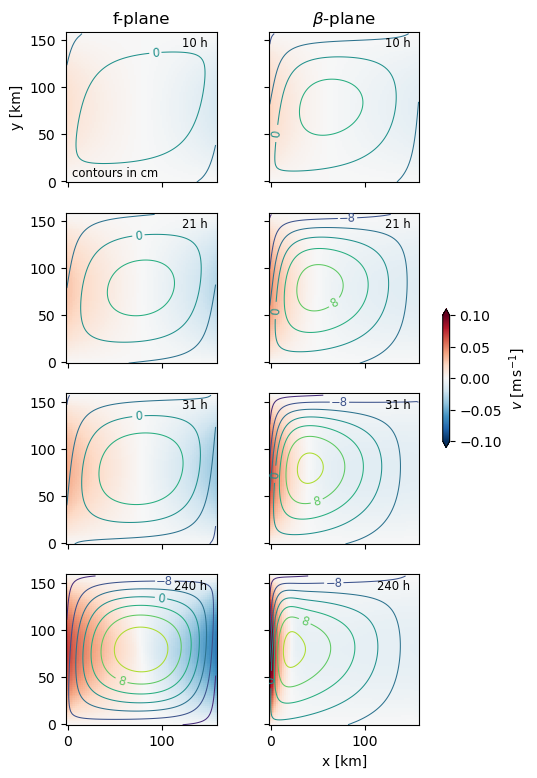

In [7]:
todo = ['basinfplane.snapshot.nc', 'basinbetaplane.snapshot.nc']
fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(6, 9),)
for nt, time in enumerate([10, 20, 30, -1]):
    for nn, td in enumerate(todo):
        ax = axs[nt, nn]
        with xr.open_dataset(td) as ds:
            ds = ds.isel(Time=time)
            ttime = int(ds.Time.astype('float').values / 1e9 / 3600)
            levels = np.arange(-20, 20, 4)
            cont = ax.contour(ds.xt, ds.yt, ds.psi * 100, levels=levels, linewidths=0.75, vmin=-16, vmax=16)
            cs = ax.pcolormesh(ds.xt, ds.yu, ds.v.mean(dim='zt'), vmin=-0.1, vmax=0.1, cmap='RdBu_r', rasterized=True)
            ax.set_aspect(1)
            ax.clabel(cont, levels=levels[1::2], fontsize='small')
            ax.text(0.94, 0.9, f'{ttime} h', transform=ax.transAxes, fontsize='small', ha='right')
axs[0, 0].set_title('f-plane')
axs[0, 0].text(0.04, 0.04, 'contours in cm', transform=axs[0, 0].transAxes, fontsize='small')
axs[0, 1].set_title('$\\beta$-plane')
axs[0, 0].set_ylabel('y [km]')
axs[-1, -1].set_xlabel('x [km]')
fig.colorbar(cs, ax=axs, shrink=0.2, extend='both', label='$v\ \mathrm{[m\,s^{-1}]}$')

The flows start out similar, with the expected surface convergence in the centre of the basin.  However, the convergence in the beta-plane simulation migrates west, whereas the f-plane solution stays centered.  In bot cases there is anti-cyclic (clockwise) circulation with southward flow and then northward flow on the west side. 